In [1618]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
# from xgboost import XGBoostRegressor

In [1619]:
df = pd.read_csv('updated_cleaned_data.csv')

In [1620]:
df.columns

Index(['Property ID', 'Zip code', 'City', 'Type of Property',
       'Subtype of Property', 'Price (€)', 'Construction year', 'Bedrooms',
       'Living area (m²)', 'Kitchen type', 'Furnished', 'How many fireplaces?',
       'Terrace', 'Terrace surface (m²)', 'Garden', 'Garden surface (m²)',
       'Surface of the plot (m²)', 'Number of frontages', 'Swimming pool',
       'Building condition', 'Elevator', 'Basement',
       'Primary energy consumption (kWh/m²)', 'CO₂ emission (kg CO₂/m²)',
       'Energy class', 'Heating type', 'Kitchen type scale',
       'Building condition scale', 'Region', 'Price per m²'],
      dtype='object')

In [1621]:
df_processed = df.drop(['Property ID', 'Construction year', 'City', 'Price per m²', 
                        'CO₂ emission (kg CO₂/m²)', 'Elevator', 'Primary energy consumption (kWh/m²)', 
                        'Furnished'], axis=1)

In [1622]:
df_processed.isnull().sum()

Zip code                       0
Type of Property               0
Subtype of Property            0
Price (€)                      0
Bedrooms                       0
Living area (m²)               0
Kitchen type                4631
How many fireplaces?           0
Terrace                        0
Terrace surface (m²)        3871
Garden                         0
Garden surface (m²)         2143
Surface of the plot (m²)    5872
Number of frontages         3320
Swimming pool                  0
Building condition          3609
Basement                       0
Energy class                2665
Heating type                4150
Kitchen type scale          4631
Building condition scale    3609
Region                         0
dtype: int64

In [1623]:
s = (df_processed.dtypes == 'object')
object_cols = list(s[s].index)
OH_encoder = OneHotEncoder(sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(df_processed[object_cols]))
OH_cols.index = df_processed.index
OH_cols.columns = OH_encoder.get_feature_names_out()
df_processed = df_processed.drop(object_cols, axis=1)
df_processed = pd.concat([df_processed, OH_cols], axis=1)


/Users/saidkardic/Desktop/immoweb_project/immo_eliza_regression/venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [1624]:
df_processed = df_processed.drop(['Kitchen type_nan', 'Building condition_nan', 
                                  'Energy class_nan', 'Heating type_nan'], axis=1)

In [1625]:

imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
imputed_columns = ['Terrace surface (m²)', 'Garden surface (m²)', 'Surface of the plot (m²)',
                                     'Number of frontages', 'Kitchen type scale', 'Building condition scale']
imputer = imputer.fit(df_processed[imputed_columns])
df_processed[imputed_columns] = imputer.transform(df_processed[imputed_columns])

In [1626]:
def subset_by_iqr(df, column, whisker_width=1.5):
    """Remove outliers from a dataframe by column, including optional 
       whiskers, removing rows for which the column value are 
       less than Q1-1.5IQR or greater than Q3+1.5IQR.
    Args:
        df (`:obj:pd.DataFrame`): A pandas dataframe to subset
        column (str): Name of the column to calculate the subset from.
        whisker_width (float): Optional, loosen the IQR filter by a
                               factor of `whisker_width` * IQR.
    Returns:
        (`:obj:pd.DataFrame`): Filtered dataframe
    """
    # Calculate Q1, Q2 and IQR
    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    # Apply filter with respect to IQR, including optional whiskers
    filter = (df[column] >= q1 - whisker_width*iqr) & (df[column] <= q3 + whisker_width*iqr)
    return df.loc[filter]                                                     

# Example for whiskers = 1.5, as requested by the OP
df_processed = subset_by_iqr(df_processed, 'Living area (m²)', whisker_width=1.5)

In [1627]:
df_processed = subset_by_iqr(df_processed, 'Price (€)', whisker_width=1.5)
df_processed = subset_by_iqr(df_processed, 'Bedrooms', whisker_width=1.5)
df_processed = subset_by_iqr(df_processed, 'Terrace surface (m²)', whisker_width=1.5)
df_processed = subset_by_iqr(df_processed, 'Garden surface (m²)', whisker_width=1.5)
df_processed = subset_by_iqr(df_processed, 'Surface of the plot (m²)', whisker_width=1.5)

In [1628]:
df_processed.shape

(11475, 82)

In [1629]:
X = df_processed.drop(['Zip code', 'Price (€)'], axis=1)
y = df_processed['Price (€)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

Linear regressıon

In [1630]:
reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

print(mean_absolute_error(y_pred=y_pred, y_true=y_test))
print(reg.score(X_test, y_test))

85907.78612953307
0.5843260295203747


In [1568]:
# X = df_processed.drop(['Zip code', 'Price (€)'], axis=1)
# y = df_processed['Price (€)']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)

# reg = LinearRegression()
# reg = reg.fit(X_train_scaled, y_train)
# X_test_scaled = scaler.transform(X_test)

# y_pred = reg.predict(X_test_scaled)


In [1586]:
# y_pred[:10], y_test[:10]
# print(reg.score(y_pred, y_test))

(array([220672., 255488., 318464., 438272., 495104., 544768., 365568.,
        529920., 376832., 382976.]),
 array([215000, 369000, 965000, 317000, 389000, 825000, 379000, 656897,
        348000, 429000]))

In [1254]:
df_houses = df_processed[df_processed['Type of Property_house'] == 1.0]
df_apartments = df_processed[df_processed['Type of Property_apartment'] == 1.0]

In [1229]:
# Regression for only houses
X = df_houses.drop(['Zip code', 'Price (€)'], axis=1).values
y = df_houses['Price (€)'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(reg.score(X_test, y_test))

0.6202324486486466


Text(0, 0.5, 'Predict price')

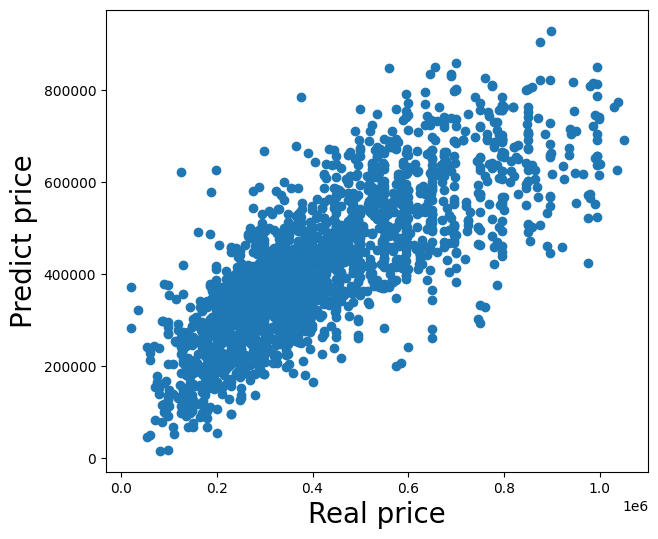

In [1230]:
# Plot for houses regression
y_pred = reg.predict(X_test)
plt.figure(figsize=(7, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('Real price', fontsize=20)
plt.ylabel('Predict price', fontsize=20)

In [1256]:
# Regression for only apartments
X = df_apartments.drop(['Zip code', 'Price (€)', 'Number of frontages', 'Swimming pool', 'Surface of the plot (m²)'], axis=1).values
y = df_apartments['Price (€)'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(reg.score(X_test, y_test))

0.4603439925203946


Text(0, 0.5, 'Predict price')

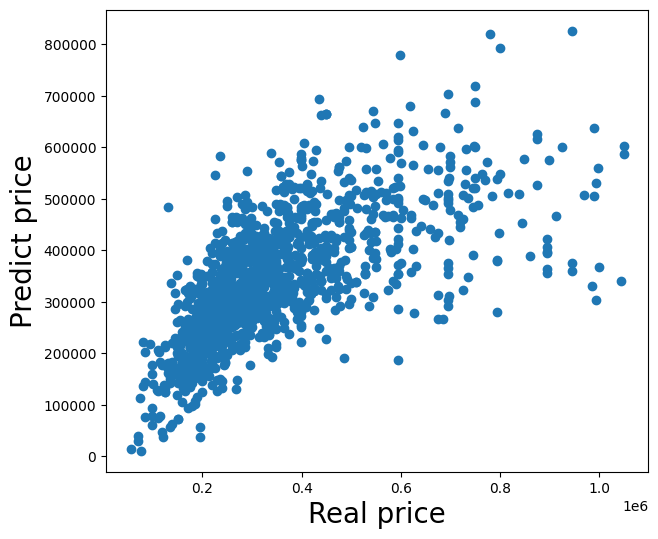

In [1206]:
# Plot for apartments regression
y_pred = reg.predict(X_test)
plt.figure(figsize=(7, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('Real price', fontsize=20)
plt.ylabel('Predict price', fontsize=20)

In [1158]:
# mean_squared_error(y_test, y_pred, squared=False)

126812.59716181774

In [ ]:
# X = df_processed[['Living area (m²)', 'Swimming pool', 'Bedrooms',
# 'Terrace', 'Terrace surface (m²)', 'Garden', 'Garden surface (m²)', 
# 'Furnished', 'How many fireplaces?']].values

# y = df['Price (€)'].values

In [573]:
# df_pro_num = df_processed[['Zip code', 'Price (€)', 'Bedrooms',
#        'Living area (m²)', 'How many fireplaces?', 'Terrace', 'Terrace surface (m²)', 
#        'Garden', 'Garden surface (m²)', 'Surface of the plot (m²)', 'Number of frontages', 
#        'Swimming pool', 'Basement', 'Kitchen type scale', 'Building condition scale']]

# df_houses = df_processed[df_processed['Type of Property'] == 'house']
# df_h_num = df_houses[['Zip code', 'Price (€)', 'Bedrooms',
#        'Living area (m²)', 'How many fireplaces?', 'Terrace', 'Terrace surface (m²)', 
#        'Garden', 'Garden surface (m²)', 'Surface of the plot (m²)', 'Number of frontages', 
#        'Swimming pool', 'Basement', 'Kitchen type scale', 'Building condition scale']]

# df_apartments = df_processed[df_processed['Type of Property'] == 'apartment']
# df_a_num = df_apartments[['Zip code', 'Price (€)', 'Bedrooms',
#        'Living area (m²)', 'How many fireplaces?', 'Terrace', 'Terrace surface (m²)', 
#        'Garden', 'Garden surface (m²)', 'Surface of the plot (m²)', 'Number of frontages', 
#        'Swimming pool', 'Basement', 'Kitchen type scale', 'Building condition scale']]

In [574]:
# obj = (df_processed.dtypes == 'object')
# object_cols = list(obj[obj].index)
# print("Categorical variables:",len(object_cols))
 
# int_ = (df_processed.dtypes == 'int')
# num_cols = list(int_[int_].index)
# print("Integer variables:",len(num_cols))
 
# fl = (df_processed.dtypes == 'float')
# fl_cols = list(fl[fl].index)
# print("Float variables:",len(fl_cols))

Categorical variables: 7
Integer variables: 6
Float variables: 12


<Axes: >

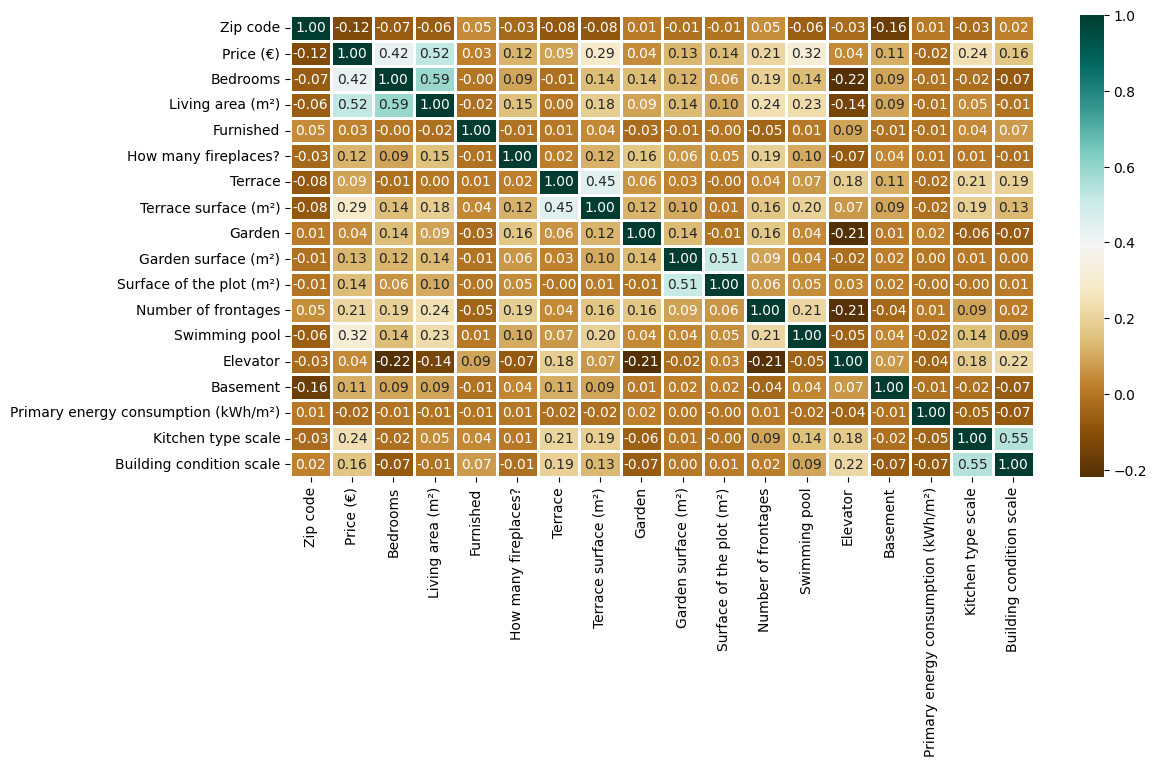

In [575]:
# plt.figure(figsize=(12, 6))
# sns.heatmap(df_pro_num.corr(),
#             cmap = 'BrBG',
#             fmt = '.2f',
#             linewidths = 2,
#             annot = True)

<Axes: >

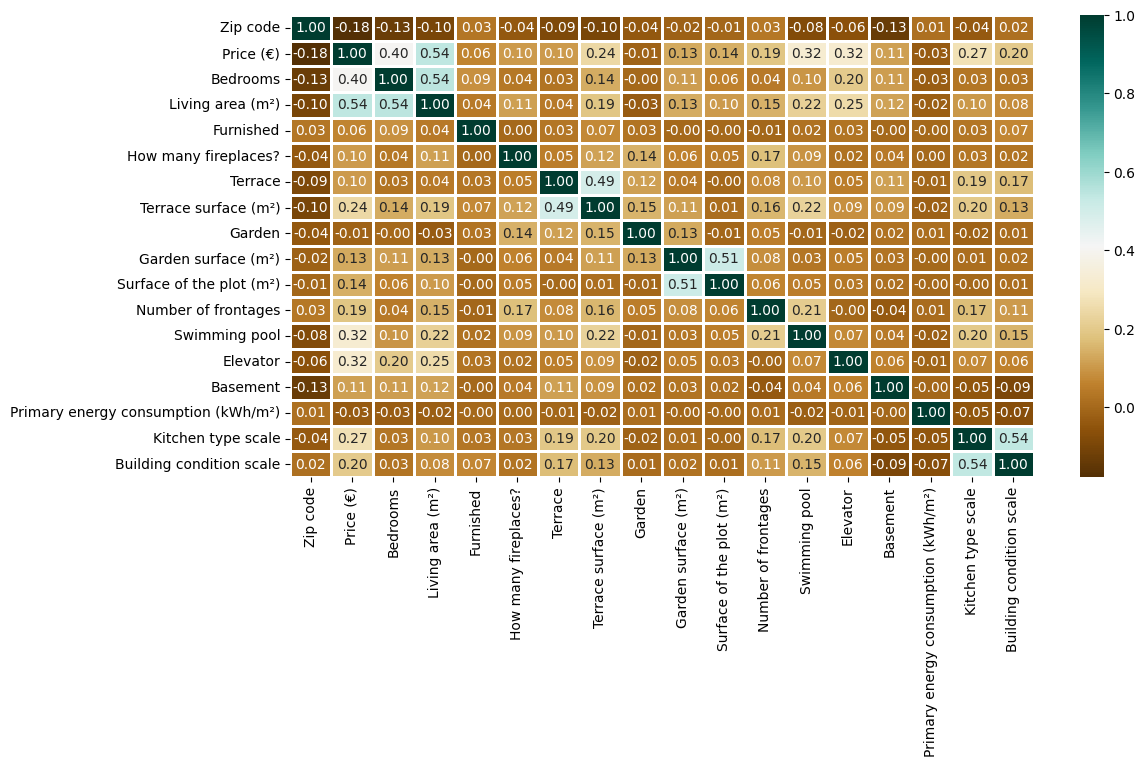

In [576]:
# plt.figure(figsize=(12, 6))
# sns.heatmap(df_h_num.corr(),
#             cmap = 'BrBG',
#             fmt = '.2f',
#             linewidths = 2,
#             annot = True)

<Axes: >

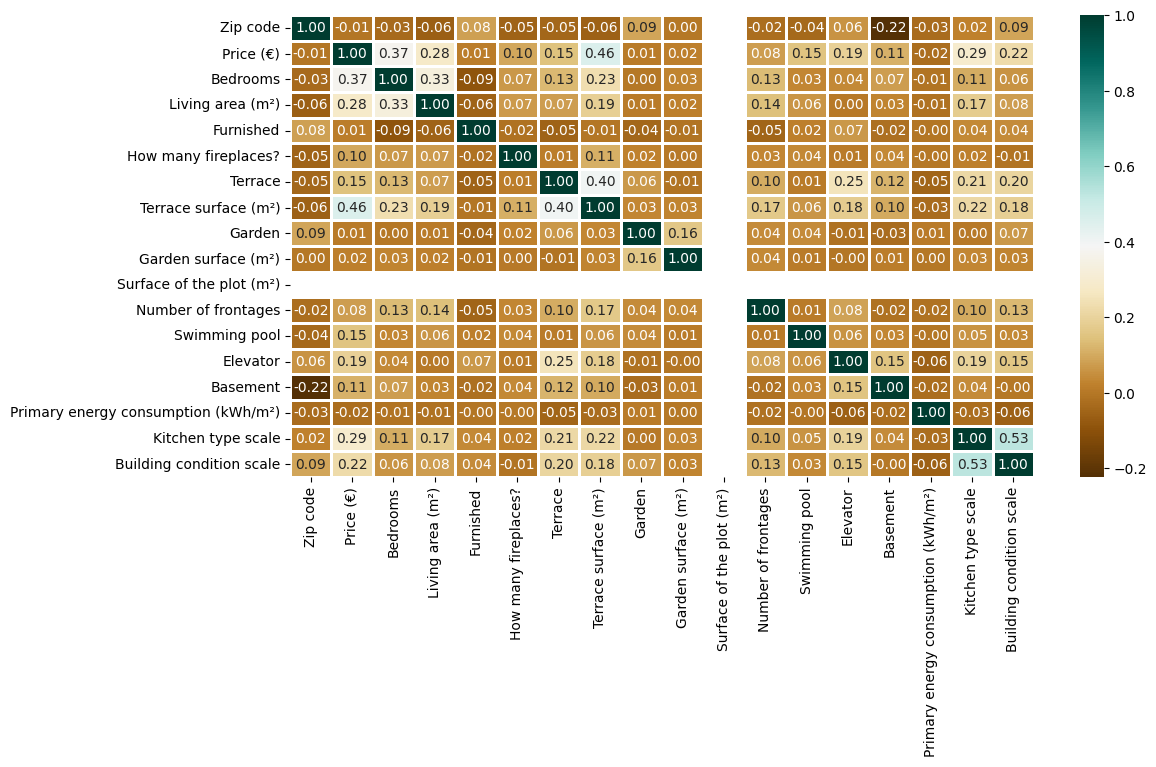

In [577]:
# plt.figure(figsize=(12, 6))
# sns.heatmap(df_a_num.corr(),
#             cmap = 'BrBG',
#             fmt = '.2f',
#             linewidths = 2,
#             annot = True)

<Axes: title={'center': 'No. Unique values of Categorical Features'}>

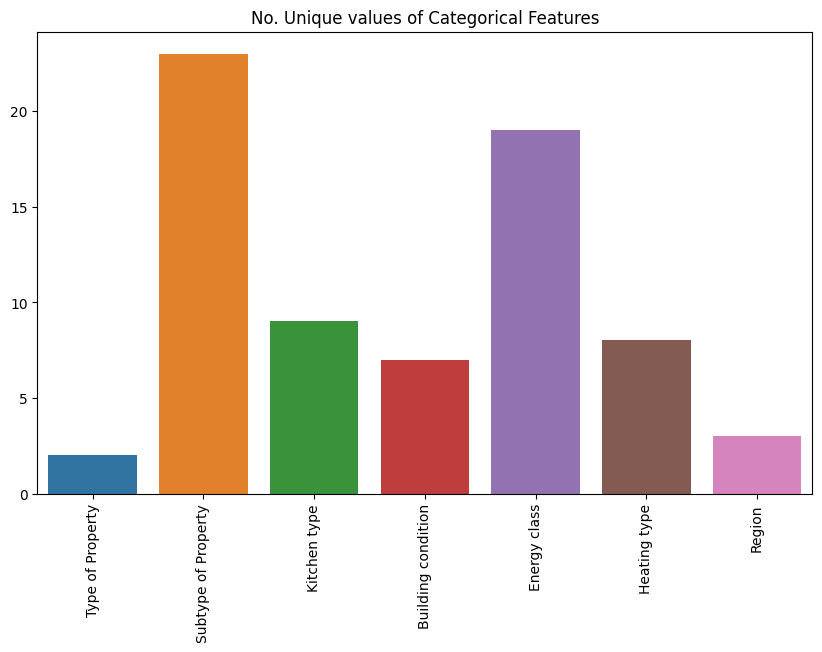

In [578]:
# unique_values = []
# for col in object_cols:
#   unique_values.append(df_processed[col].unique().size)
# plt.figure(figsize=(10,6))
# plt.title('No. Unique values of Categorical Features')
# plt.xticks(rotation=90)
# sns.barplot(x=object_cols,y=unique_values)

/var/folders/9g/mm9pdxg52dn6rg0rtfk14syc0000gn/T/ipykernel_70866/2838185598.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(11, 4, index)


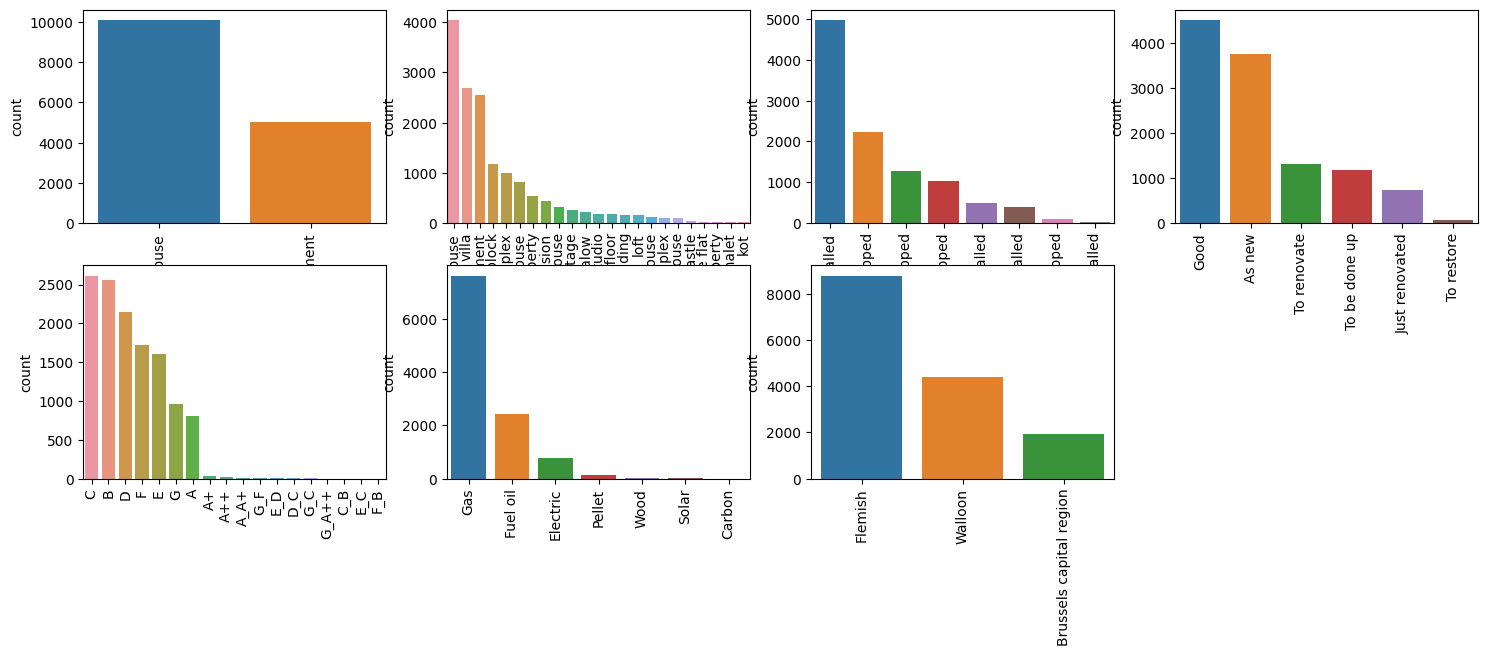

In [579]:
# plt.figure(figsize=(18, 36))
# plt.title('Categorical Features: Distribution')
# plt.xticks(rotation=90)
# index = 1
 
# for col in object_cols:
#     y = df_processed[col].value_counts()
#     plt.subplot(11, 4, index)
#     plt.xticks(rotation=90)
#     sns.barplot(x=list(y.index), y=y)
#     index += 1

In [460]:
# print(df_processed['Living area (m²)'].describe())

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# X = df_processed.drop(['Zip code', 'Price (€)'], axis=1).values
# y = df_processed['Price (€)'].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
# forest = RandomForestRegressor()
# forest.fit(X_train, y_train)
# print(forest.score(X_test, y_test))